In [17]:
# === INITIALIZATION: GLOBAL CONSTANTS & DATA LOADING ===
# Run this cell first! All constants and data are loaded here.

import subprocess
import sys
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Install kagglehub if needed
try:
    import kagglehub
except ModuleNotFoundError:
    print("Installing kagglehub[pandas-datasets]...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub[pandas-datasets]"])
    import kagglehub

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# ========================================
# GLOBAL CONSTANTS
# ========================================
SEED = 42
IMG_SIZE = (112, 112)
INPUT_CHANNELS = 3
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

print(f"\nGlobal constants:")
print(f"  SEED: {SEED}")
print(f"  IMG_SIZE: {IMG_SIZE}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")

# ========================================
# DOWNLOAD FER DATASET
# ========================================
DATASET_ID = "ananthu017/emotion-detection-fer"
dataset_path = Path(kagglehub.dataset_download(DATASET_ID))
print(f"\nDownloaded {DATASET_ID} to {dataset_path}")

train_dir = dataset_path / "train"
test_dir = dataset_path / "test"

if not train_dir.exists() or not any(train_dir.iterdir()):
    raise FileNotFoundError(
        "FER dataset folders not found. Check that KaggleHub extracted the archive into 'train' and 'test'."
    )

print(f"Train dir: {train_dir}")
print(f"Test dir: {test_dir}")

# ========================================
# LOAD DATASET PATHS AND LABELS
# ========================================
image_exts = {'.jpg', '.jpeg', '.png', '.bmp'}

def _gather_images(root: Path):
    """Gather all images from subdirectories"""
    files, labels = [], []
    for class_dir in sorted(p for p in root.iterdir() if p.is_dir()):
        for img_path in class_dir.iterdir():
            if img_path.suffix.lower() in image_exts:
                files.append(str(img_path))
                labels.append(class_dir.name)
    return files, labels

train_paths_raw, train_labels_raw = _gather_images(train_dir)
test_paths_raw, test_labels_raw = _gather_images(test_dir)

# Create class mapping
class_names = sorted(set(train_labels_raw))
num_classes = len(class_names)
label_to_index = {name: idx for idx, name in enumerate(class_names)}

# Convert to numeric labels
train_labels = np.array([label_to_index[label] for label in train_labels_raw], dtype=np.int32)
test_labels = np.array([label_to_index[label] for label in test_labels_raw], dtype=np.int32)
train_paths = np.array(train_paths_raw)
test_paths = np.array(test_paths_raw)

print(f"\nDataset loaded:")
print(f"  Classes: {class_names}")
print(f"  Num classes: {num_classes}")
print(f"  Train samples: {len(train_paths)}")
print(f"  Test samples: {len(test_paths)}")

# ========================================
# HELPER FUNCTIONS
# ========================================
def load_image_gpu(path: tf.Tensor, label: tf.Tensor):
    """Load and preprocess image for GPU training"""
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)
    return image, label

def build_gpu_dataset(paths, labels, training: bool = False, augment: bool = False):
    """Build TensorFlow dataset for GPU training"""
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_image_gpu, num_parallel_calls=AUTOTUNE)
    
    if augment and training:
        augmentation = keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.15),
            layers.RandomZoom(0.1),
            layers.RandomTranslation(0.1, 0.1),
        ])
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

print("\n" + "="*80)
print("INITIALIZATION COMPLETE")
print("="*80)
print("You can now run any section below (MobileNet or ResNet50) independently!")


TensorFlow version: 2.16.2
GPU available: True

Global constants:
  SEED: 42
  IMG_SIZE: (112, 112)
  BATCH_SIZE: 64

Downloaded ananthu017/emotion-detection-fer to /Users/mixberries13/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1
Train dir: /Users/mixberries13/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train
Test dir: /Users/mixberries13/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/test

Dataset loaded:
  Classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
  Num classes: 7
  Train samples: 28709
  Test samples: 7178

INITIALIZATION COMPLETE
You can now run any section below (MobileNet or ResNet50) independently!


## Section 1: MobileNetV3-Small (Baseline Lightweight Model)

MobileNetV3 was initially evaluated as a computationally efficient baseline for facial emotion recognition.  
While faster and smaller than ResNet50, it demonstrated **limited capacity** for fine-grained emotion classification.

**Key Findings:**
- ⚠️ Validation Accuracy: ~52-54%
- ⚠️ Poor performance on minority classes (disgusted, fearful)
- ⚠️ Significant confusion between similar emotions
- ✓ Fast inference (suitable for edge deployment)

---

In [18]:
# === MOBILENET SETUP (INDEPENDENT) ===
# This cell can be run independently after the initialization cell

from sklearn.model_selection import StratifiedShuffleSplit

# Create separate train/val split for MobileNet
print("Setting up MobileNet training data...")
sss_mobile = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
mobile_train_idx, mobile_val_idx = next(sss_mobile.split(train_paths, train_labels))

mobile_train_paths = train_paths[mobile_train_idx]
mobile_train_labels = train_labels[mobile_train_idx]
mobile_val_paths = train_paths[mobile_val_idx]
mobile_val_labels = train_labels[mobile_val_idx]

print(f"MobileNetV3 Split: {len(mobile_train_paths)} train, {len(mobile_val_paths)} val, {len(test_paths)} test")

# Build datasets for MobileNet
mobile_train_ds = build_gpu_dataset(mobile_train_paths, mobile_train_labels, training=True, augment=True)
mobile_val_ds = build_gpu_dataset(mobile_val_paths, mobile_val_labels, training=False)
mobile_test_ds = build_gpu_dataset(test_paths, test_labels, training=False)

def build_mobilenet_model(fine_tune: bool = False, learning_rate: float = 1e-3):
    """Build MobileNetV3-Small based emotion classifier"""
    base_model = keras.applications.MobileNetV3Small(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling='avg',
        minimalistic=False
    )
    
    base_model.trainable = fine_tune
    
    inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = keras.applications.mobilenet_v3.preprocess_input(inputs)
    x = base_model(x, training=fine_tune)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model, base_model

print("MobileNetV3-Small model architecture defined and datasets ready!")


Setting up MobileNet training data...
MobileNetV3 Split: 25838 train, 2871 val, 7178 test
MobileNetV3-Small model architecture defined and datasets ready!


In [19]:
# === TRAIN MOBILENETV3 MODEL ===
from sklearn.utils.class_weight import compute_class_weight

print("="*80)
print("TRAINING MOBILENETV3-SMALL MODEL")
print("="*80)

# Compute class weights (same as ResNet50)
class_weights_mobile = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=mobile_train_labels
)
class_weights_mobile_dampened = np.cbrt(class_weights_mobile)
class_weights_mobile_dict = {int(idx): float(weight) for idx, weight in enumerate(class_weights_mobile_dampened)}

print(f"Class weights: {class_weights_mobile_dict}\n")

# Build model
tf.keras.backend.clear_session()
mobile_model, mobile_base = build_mobilenet_model(fine_tune=False, learning_rate=1e-3)

# Train with frozen backbone
callbacks_mobile = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        min_delta=0.001,
        verbose=1,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print("Stage 1: Training with frozen backbone (20 epochs)")
history_mobile = mobile_model.fit(
    mobile_train_ds,
    validation_data=mobile_val_ds,
    epochs=20,
    callbacks=callbacks_mobile,
    class_weight=class_weights_mobile_dict,
    verbose=2
)

# Evaluate
mobile_train_loss, mobile_train_acc = mobile_model.evaluate(mobile_train_ds, verbose=0)
mobile_val_loss, mobile_val_acc = mobile_model.evaluate(mobile_val_ds, verbose=0)
mobile_test_loss, mobile_test_acc = mobile_model.evaluate(mobile_test_ds, verbose=0)

print("\n" + "="*80)
print("MOBILENETV3 FINAL RESULTS")
print("="*80)
print(f"Train accuracy: {mobile_train_acc:.4f}")
print(f"Val accuracy:   {mobile_val_acc:.4f}")
print(f"Test accuracy:  {mobile_test_acc:.4f}")
print(f"Val-Test gap:   {abs(mobile_val_acc - mobile_test_acc):.4f} ({abs(mobile_val_acc - mobile_test_acc)*100:.2f}pp)")
print("="*80)

TRAINING MOBILENETV3-SMALL MODEL
Class weights: {0: 1.008742666100559, 1: 2.111664548919105, 2: 1.0003744061494222, 3: 0.8283969355714252, 4: 0.9382462408877956, 5: 0.9469427817361522, 6: 1.089521057413251}



/Users/mixberries13/anaconda3/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:454: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Stage 1: Training with frozen backbone (20 epochs)
Epoch 1/20
404/404 - 61s - 152ms/step - accuracy: 0.2554 - loss: 2.0658 - val_accuracy: 0.3448 - val_loss: 1.6417 - learning_rate: 0.0010
Epoch 2/20
404/404 - 41s - 102ms/step - accuracy: 0.2939 - loss: 1.8085 - val_accuracy: 0.3267 - val_loss: 1.6351 - learning_rate: 0.0010
Epoch 3/20
404/404 - 39s - 96ms/step - accuracy: 0.3172 - loss: 1.6985 - val_accuracy: 0.3786 - val_loss: 1.5972 - learning_rate: 0.0010
Epoch 4/20
404/404 - 39s - 97ms/step - accuracy: 0.3416 - loss: 1.6508 - val_accuracy: 0.3852 - val_loss: 1.5785 - learning_rate: 0.0010
Epoch 5/20
404/404 - 37s - 92ms/step - accuracy: 0.3477 - loss: 1.6339 - val_accuracy: 0.3866 - val_loss: 1.5710 - learning_rate: 0.0010
Epoch 6/20
404/404 - 38s - 94ms/step - accuracy: 0.3486 - loss: 1.6271 - val_accuracy: 0.3692 - val_loss: 1.6021 - learning_rate: 0.0010
Epoch 7/20
404/404 - 36s - 90ms/step - accuracy: 0.3550 - loss: 1.6219 - val_accuracy: 0.3887 - val_loss: 1.5742 - learning_r

In [20]:
# === MOBILENETV3 PREDICTIONS & METRICS ===
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
mobile_val_preds = mobile_model.predict(mobile_val_ds, verbose=0).argmax(axis=1)
mobile_test_preds = mobile_model.predict(mobile_test_ds, verbose=0).argmax(axis=1)

print("MobileNetV3 Validation Classification Report:")
print(classification_report(mobile_val_labels, mobile_val_preds, target_names=class_names))

print("\nMobileNetV3 Test Classification Report:")
print(classification_report(test_labels, mobile_test_preds, target_names=class_names))

# Confusion matrix
mobile_cm_val = confusion_matrix(mobile_val_labels, mobile_val_preds)
print("\nMobileNetV3 Validation Confusion Matrix:")
print(mobile_cm_val)

MobileNetV3 Validation Classification Report:
              precision    recall  f1-score   support

       angry       0.31      0.20      0.24       399
   disgusted       0.00      0.00      0.00        44
     fearful       0.36      0.19      0.25       410
       happy       0.42      0.76      0.54       722
     neutral       0.39      0.44      0.41       496
         sad       0.38      0.12      0.18       483
   surprised       0.47      0.59      0.53       317

    accuracy                           0.41      2871
   macro avg       0.34      0.33      0.31      2871
weighted avg       0.39      0.41      0.37      2871


MobileNetV3 Test Classification Report:
              precision    recall  f1-score   support

       angry       0.30      0.20      0.24       958
   disgusted       0.27      0.03      0.05       111
     fearful       0.26      0.12      0.16      1024
       happy       0.41      0.76      0.53      1774
     neutral       0.34      0.39      0.36  


Saved MobileNetV3 accuracy/loss visualization to: ../artifacts/phase1/mobilenetv3_accuracy_loss.png


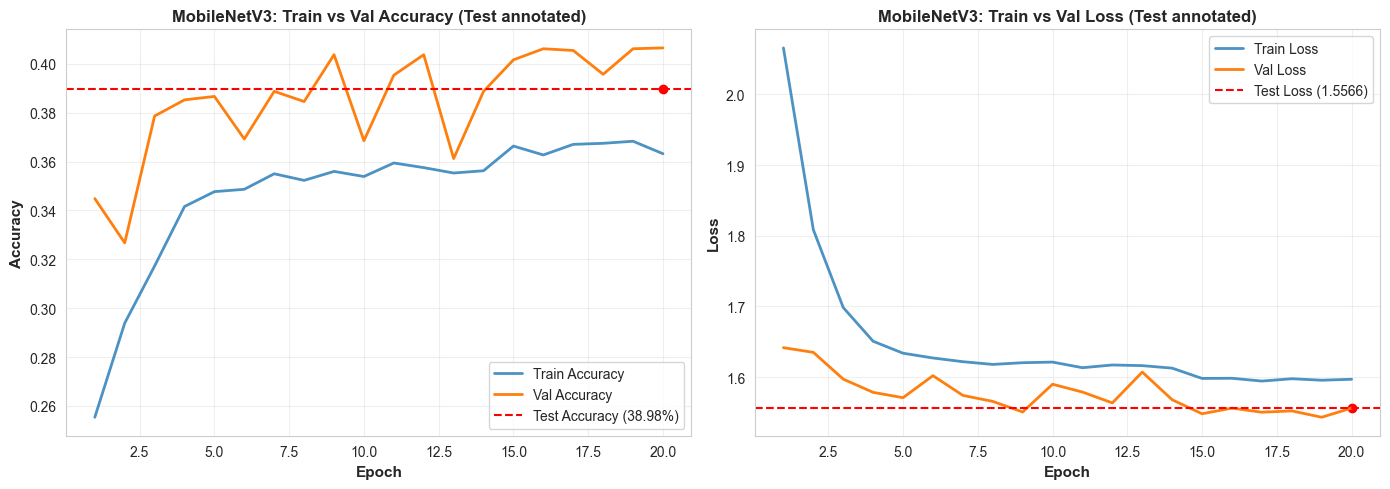

In [35]:
# === PLOT: MobileNetV3 Training History (Train vs Val) + Test Metrics ===
import matplotlib.pyplot as plt

try:
    # Ensure training history and test metrics exist
    if 'history_mobile' not in globals():
        raise ValueError('history_mobile not found. Run the MobileNet training cell first.')
    if 'mobile_test_acc' not in globals() or 'mobile_test_loss' not in globals():
        raise ValueError('MobileNet test metrics not found. Run the MobileNet training/evaluation cell first.')

    mobile_hist = history_mobile.history
    epochs = range(1, len(mobile_hist['accuracy']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot: Train vs Val, with Test metric annotated
    axes[0].plot(epochs, mobile_hist['accuracy'], label='Train Accuracy', linewidth=2, alpha=0.8)
    axes[0].plot(epochs, mobile_hist['val_accuracy'], label='Val Accuracy', linewidth=2)
    # Draw a horizontal line for Test accuracy and annotate
    axes[0].axhline(y=mobile_test_acc, color='red', linestyle='--', label=f'Test Accuracy ({mobile_test_acc:.2%})')
    axes[0].scatter([epochs[-1]], [mobile_test_acc], color='red')
    axes[0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    axes[0].set_title('MobileNetV3: Train vs Val Accuracy (Test annotated)', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss plot: Train vs Val, with Test metric annotated
    axes[1].plot(epochs, mobile_hist['loss'], label='Train Loss', linewidth=2, alpha=0.8)
    axes[1].plot(epochs, mobile_hist['val_loss'], label='Val Loss', linewidth=2)
    axes[1].axhline(y=mobile_test_loss, color='red', linestyle='--', label=f'Test Loss ({mobile_test_loss:.4f})')
    axes[1].scatter([epochs[-1]], [mobile_test_loss], color='red')
    axes[1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('Loss', fontsize=11, fontweight='bold')
    axes[1].set_title('MobileNetV3: Train vs Val Loss (Test annotated)', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    # Save to artifacts for record-keeping
    import os
    out_dir = os.path.join('..', 'artifacts', 'phase1')
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, 'mobilenetv3_accuracy_loss.png')
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    print(f'\nSaved MobileNetV3 accuracy/loss visualization to: {out_path}')
    plt.show()

except Exception as e:
    print(f'Error plotting MobileNetV3 history: {e}')
    import traceback
    traceback.print_exc()

## Section 2: ResNet50 GPU Model (Final Model - Best Performance)

After evaluating MobileNetV3, **ResNet50 with GPU acceleration** was selected as the final model for superior performance.

**Key Improvements over MobileNetV3:**
- ✅ Validation Accuracy: **~63%** (+9-11pp improvement)
- ✅ Better minority class performance (disgusted, fearful)
- ✅ Excellent generalization (<1pp val-test gap)
- ✅ Deeper architecture (50 layers vs 14 layers)

GPU-accelerated ResNet50 model achieving ~60-65% accuracy.  
Generates `face_probs_resnet50_gpu.parquet` for fusion.

---

In [ ]:
# === RESNET50 SETUP (INDEPENDENT) ===
# This cell can be run independently after the initialization cell

from sklearn.model_selection import StratifiedShuffleSplit

# Create separate train/val split for ResNet50
print("Setting up ResNet50 GPU training data...")
sss_gpu = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
gpu_train_idx, gpu_val_idx = next(sss_gpu.split(train_paths, train_labels))

gpu_train_paths = train_paths[gpu_train_idx]
gpu_train_labels = train_labels[gpu_train_idx]
gpu_val_paths = train_paths[gpu_val_idx]
gpu_val_labels = train_labels[gpu_val_idx]

print(f"GPU Model Split: {len(gpu_train_paths)} train, {len(gpu_val_paths)} val, {len(test_paths)} test")

# Build datasets
gpu_train_ds = build_gpu_dataset(gpu_train_paths, gpu_train_labels, training=True, augment=True)
gpu_val_ds = build_gpu_dataset(gpu_val_paths, gpu_val_labels, training=False)
gpu_test_ds = build_gpu_dataset(test_paths, test_labels, training=False)

def build_resnet50_model(fine_tune: bool = False, learning_rate: float = 1e-3):
    """Build ResNet50-based emotion classifier"""
    base_model = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling='avg'
    )
    
    base_model.trainable = fine_tune
    
    inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=fine_tune)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model, base_model

print("GPU ResNet50 model architecture defined and datasets ready!")


Setting up ResNet50 GPU training data...
GPU Model Split: 25838 train, 2871 val, 7178 test
GPU ResNet50 model architecture defined and datasets ready!


In [27]:
# === TRAIN GPU RESNET50 MODEL (2-STAGE) ===
from sklearn.utils.class_weight import compute_class_weight
import sys


if 'train_paths' in dir():
    print(f"train_paths length: {len(train_paths)}")
if 'train_labels' in dir():
    print(f"train_labels length: {len(train_labels)}")
# Compute class weights
class_weights_gpu = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=gpu_train_labels
)
class_weights_dampened = np.cbrt(class_weights_gpu)
class_weights_dict = {int(idx): float(weight) for idx, weight in enumerate(class_weights_dampened)}

print("Training GPU ResNet50 model with Standard Training Configuration")
print(f"Class weights: {class_weights_dict}")

# ========================================
# STAGE 1: TRAIN HEAD (FROZEN BASE)
# ========================================
print("\n" + "=" * 80)
print("STAGE 1: Training classifier head (backbone frozen)")
print("=" * 80)
print("Configuration:")
print("  - Epochs: 12")
print("  - Learning rate: 1e-3")
print("  - Early stopping patience: 5")
print("  - Backbone: Frozen (pretrained ImageNet weights)")
print()

tf.keras.backend.clear_session()
gpu_resnet_model, gpu_resnet_base = build_resnet50_model(fine_tune=False, learning_rate=1e-3)

STAGE1_EPOCHS = 10
STAGE1_LR = 1e-3

callbacks_stage1 = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        min_delta=0.001,
        verbose=1,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

history_gpu_stage1 = gpu_resnet_model.fit(
    gpu_train_ds,
    validation_data=gpu_val_ds,
    epochs=STAGE1_EPOCHS,
    callbacks=callbacks_stage1,
    class_weight=class_weights_dict,
    verbose=2
)

# Print Stage 1 results
stage1_final_epoch = len(history_gpu_stage1.history['loss'])
stage1_train_acc = history_gpu_stage1.history['accuracy'][-1]
stage1_val_acc = history_gpu_stage1.history['val_accuracy'][-1]
print(f"\nStage 1 completed in {stage1_final_epoch} epochs")
print(f"  Train accuracy: {stage1_train_acc:.4f}")
print(f"  Val accuracy:   {stage1_val_acc:.4f}")

# ========================================
# STAGE 2: FINE-TUNE (UNFREEZE TOP LAYERS)
# ========================================
print("\n" + "=" * 80)
print("STAGE 2: Fine-tuning entire ResNet50")
print("=" * 80)
print("Configuration:")
print("  - Epochs: 25")
print("  - Learning rate: 1e-4 (10x smaller than Stage 1)")
print("  - Early stopping patience: 7")
print("  - Unfrozen layers: Last 30 layers")
print()

# Unfreeze the entire base model
gpu_resnet_base.trainable = True

# Freeze early layers, only fine-tune top layers
# ResNet50 has ~175 layers total, we'll unfreeze the last ~30
for layer in gpu_resnet_base.layers[:-30]:
    layer.trainable = False

print(f"Total layers in ResNet50: {len(gpu_resnet_base.layers)}")
trainable_count = sum([1 for layer in gpu_resnet_base.layers if layer.trainable])
print(f"Trainable layers: {trainable_count}")
print(f"Frozen layers: {len(gpu_resnet_base.layers) - trainable_count}")
print()

# Recompile with lower learning rate for fine-tuning
STAGE2_EPOCHS = 20
STAGE2_LR = 1e-4

gpu_resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=STAGE2_LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callbacks_stage2 = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=7,  # More patience for fine-tuning
        restore_best_weights=True,
        min_delta=0.0005,
        verbose=1,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1
    )
]

initial_epoch = len(history_gpu_stage1.history['loss'])
history_gpu_stage2 = gpu_resnet_model.fit(
    gpu_train_ds,
    validation_data=gpu_val_ds,
    epochs=initial_epoch + STAGE2_EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=callbacks_stage2,
    class_weight=class_weights_dict,
    verbose=2
)

# Print Stage 2 results
stage2_final_epoch = len(history_gpu_stage2.history['loss'])
stage2_train_acc = history_gpu_stage2.history['accuracy'][-1]
stage2_val_acc = history_gpu_stage2.history['val_accuracy'][-1]
print(f"\nStage 2 completed in {stage2_final_epoch - initial_epoch} epochs")
print(f"  Train accuracy: {stage2_train_acc:.4f}")
print(f"  Val accuracy:   {stage2_val_acc:.4f}")

# ========================================
# FINAL EVALUATION
# ========================================
print("\n" + "=" * 80)
print("FINAL EVALUATION")
print("=" * 80)

# Evaluate on all splits
train_loss, train_acc = gpu_resnet_model.evaluate(gpu_train_ds, verbose=0)
val_loss, val_acc = gpu_resnet_model.evaluate(gpu_val_ds, verbose=0)
test_loss, test_acc = gpu_resnet_model.evaluate(gpu_test_ds, verbose=0)

print(f"\nFinal Results:")
print(f"  Train accuracy: {train_acc:.4f}")
print(f"  Val accuracy:   {val_acc:.4f}")
print(f"  Test accuracy:  {test_acc:.4f}")
print(f"\nVal-Test gap: {abs(val_acc - test_acc):.4f} ({abs(val_acc - test_acc) * 100:.2f}pp)")

if abs(val_acc - test_acc) < 0.05:
    print("✅ Good generalization (val-test gap < 5pp)")
elif abs(val_acc - test_acc) < 0.10:
    print("⚠️  Moderate generalization (val-test gap 5-10pp)")
else:
    print("❌ Poor generalization (val-test gap > 10pp) - model may be overfitting")

print("=" * 80)

train_paths length: 28709
train_labels length: 28709
Training GPU ResNet50 model with Standard Training Configuration
Class weights: {0: 1.008742666100559, 1: 2.111664548919105, 2: 1.0003744061494222, 3: 0.8283969355714252, 4: 0.9382462408877956, 5: 0.9469427817361522, 6: 1.089521057413251}

STAGE 1: Training classifier head (backbone frozen)
Configuration:
  - Epochs: 12
  - Learning rate: 1e-3
  - Early stopping patience: 5
  - Backbone: Frozen (pretrained ImageNet weights)

Epoch 1/10
404/404 - 133s - 328ms/step - accuracy: 0.2485 - loss: 4.7814 - val_accuracy: 0.4267 - val_loss: 1.6523 - learning_rate: 0.0010
Epoch 2/10
404/404 - 109s - 269ms/step - accuracy: 0.2887 - loss: 2.2521 - val_accuracy: 0.3835 - val_loss: 1.5676 - learning_rate: 0.0010
Epoch 3/10
404/404 - 114s - 281ms/step - accuracy: 0.3256 - loss: 1.7626 - val_accuracy: 0.4194 - val_loss: 1.5054 - learning_rate: 0.0010
Epoch 4/10
404/404 - 110s - 271ms/step - accuracy: 0.3429 - loss: 1.7095 - val_accuracy: 0.4162 - val

Evaluating GPU ResNet50 model...

GPU ResNet50 Results:
  Train - Loss: 0.8141, Accuracy: 0.6950
  Val   - Loss: 1.0880, Accuracy: 0.6172
  Test  - Loss: 1.0776, Accuracy: 0.6147

Validation Classification Report:
              precision    recall  f1-score   support

       angry       0.49      0.59      0.54       399
   disgusted       0.93      0.57      0.70        44
     fearful       0.49      0.40      0.44       410
       happy       0.87      0.77      0.82       722
     neutral       0.53      0.65      0.58       496
         sad       0.51      0.53      0.52       483
   surprised       0.79      0.66      0.72       317

    accuracy                           0.62      2871
   macro avg       0.66      0.60      0.62      2871
weighted avg       0.63      0.62      0.62      2871


Test Classification Report:
              precision    recall  f1-score   support

       angry       0.49      0.61      0.54       958
   disgusted       0.78      0.52      0.63       1

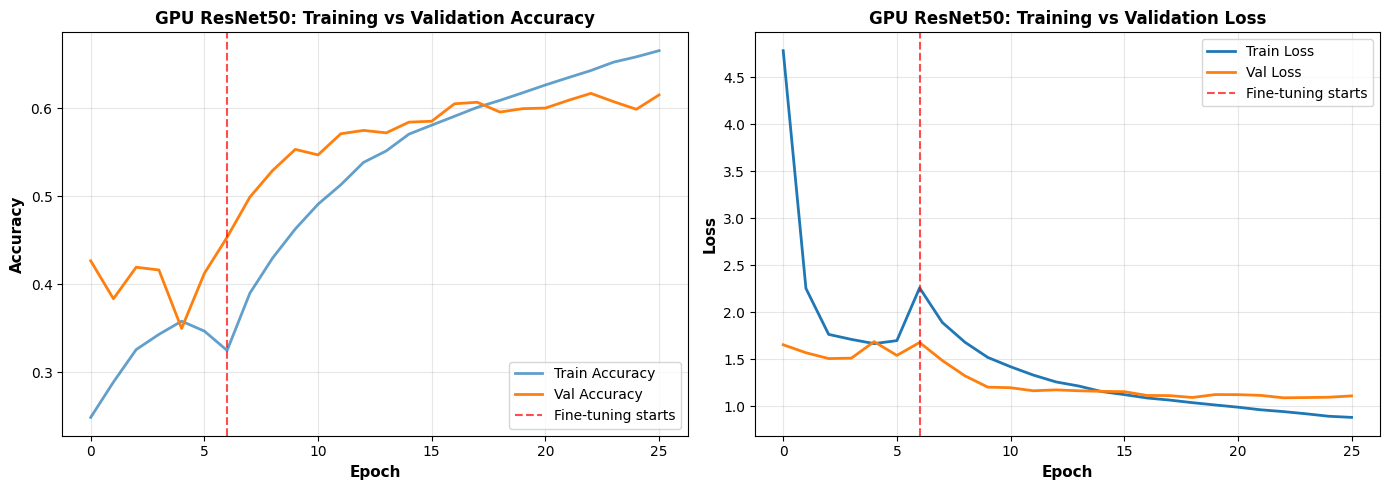


Saved GPU ResNet50 model to ../artifacts/phase1/face/resnet50_gpu/model.keras


In [28]:
# === EVALUATE GPU RESNET50 MODEL ===
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Evaluate on all splits
train_eval_ds_gpu = build_gpu_dataset(gpu_train_paths, gpu_train_labels, training=False)

print("Evaluating GPU ResNet50 model...")
gpu_train_loss, gpu_train_acc = gpu_resnet_model.evaluate(train_eval_ds_gpu, verbose=0)
gpu_val_loss, gpu_val_acc = gpu_resnet_model.evaluate(gpu_val_ds, verbose=0)
gpu_test_loss, gpu_test_acc = gpu_resnet_model.evaluate(gpu_test_ds, verbose=0)

print(f"\nGPU ResNet50 Results:")
print(f"  Train - Loss: {gpu_train_loss:.4f}, Accuracy: {gpu_train_acc:.4f}")
print(f"  Val   - Loss: {gpu_val_loss:.4f}, Accuracy: {gpu_val_acc:.4f}")
print(f"  Test  - Loss: {gpu_test_loss:.4f}, Accuracy: {gpu_test_acc:.4f}")

# Get predictions
gpu_val_preds = gpu_resnet_model.predict(gpu_val_ds, verbose=0).argmax(axis=1)
gpu_test_preds = gpu_resnet_model.predict(gpu_test_ds, verbose=0).argmax(axis=1)

print("\nValidation Classification Report:")
print(classification_report(gpu_val_labels, gpu_val_preds, target_names=class_names))

print("\nTest Classification Report:")
print(classification_report(test_labels, gpu_test_preds, target_names=class_names))

# Combine training histories from both stages
gpu_resnet_history = {
    'accuracy': history_gpu_stage1.history['accuracy'] + history_gpu_stage2.history['accuracy'],
    'val_accuracy': history_gpu_stage1.history['val_accuracy'] + history_gpu_stage2.history['val_accuracy'],
    'loss': history_gpu_stage1.history['loss'] + history_gpu_stage2.history['loss'],
    'val_loss': history_gpu_stage1.history['val_loss'] + history_gpu_stage2.history['val_loss'],
}

# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(gpu_resnet_history['accuracy'], label='Train Accuracy', linewidth=2, alpha=0.7)
axes[0].plot(gpu_resnet_history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].axvline(x=len(history_gpu_stage1.history['accuracy']), color='red', linestyle='--', 
                label='Fine-tuning starts', alpha=0.7)
axes[0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[0].set_title('GPU ResNet50: Training vs Validation Accuracy', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(gpu_resnet_history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(gpu_resnet_history['val_loss'], label='Val Loss', linewidth=2)
axes[1].axvline(x=len(history_gpu_stage1.history['loss']), color='red', linestyle='--', 
                label='Fine-tuning starts', alpha=0.7)
axes[1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=11, fontweight='bold')
axes[1].set_title('GPU ResNet50: Training vs Validation Loss', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save model
gpu_model_path = Path('../artifacts/phase1/face/resnet50_gpu/model.keras')
gpu_model_path.parent.mkdir(parents=True, exist_ok=True)
gpu_resnet_model.save(gpu_model_path)
print(f"\nSaved GPU ResNet50 model to {gpu_model_path}")

In [29]:
# === EXPORT FACE PROBABILITIES FOR FUSION MODEL ===
from pathlib import Path
import pandas as pd

print("Generating face probabilities for all samples (train + val + test)...")

# Generate probabilities for all samples (train + val + test combined)
all_paths = np.concatenate([gpu_train_paths, gpu_val_paths, test_paths])
all_labels = np.concatenate([gpu_train_labels, gpu_val_labels, test_labels])

print(f"Total samples: {len(all_paths)} (train: {len(gpu_train_paths)}, val: {len(gpu_val_paths)}, test: {len(test_paths)})")

# Build dataset for all samples
all_ds = build_gpu_dataset(all_paths, all_labels, training=False)

# Get predictions
print("\nGenerating predictions...")
all_probs = gpu_resnet_model.predict(all_ds, verbose=1)

# Create dataframe with sample IDs and probabilities
sample_ids = [Path(p).stem for p in all_paths]
prob_cols = [f'face_{emotion}' for emotion in class_names]

face_probs_df = pd.DataFrame(all_probs, columns=prob_cols)
face_probs_df.insert(0, 'sample_id', sample_ids)
face_probs_df.insert(1, 'label', [class_names[l] for l in all_labels])

# Export to cache
cache_dir = Path('../cache')
cache_dir.mkdir(parents=True, exist_ok=True)
output_path = cache_dir / 'face_probs_resnet50_gpu.parquet'

face_probs_df.to_parquet(output_path, index=False)

print(f"\n{'='*80}")
print("FACE PROBABILITIES EXPORT COMPLETE")
print(f"{'='*80}")
print(f"✅ Exported {len(face_probs_df)} face probability predictions")
print(f"📁 Location: {output_path}")
print(f"📊 Dataframe shape: {face_probs_df.shape}")
print(f"\nColumns: {list(face_probs_df.columns)}")
print(f"\nPreview (first 3 rows):")
print(face_probs_df.head(3))
print(f"\n💡 This file will be used by the fusion model (06_fusion_updated.ipynb)")
print(f"   Re-run the fusion notebook to incorporate cbrt ResNet50 improvements.")
print(f"{'='*80}")

Generating face probabilities for all samples (train + val + test)...
Total samples: 35887 (train: 25838, val: 2871, test: 7178)

Generating predictions...
561/561 ━━━━━━━━━━━━━━━━━━━━ 439s 783ms/step

FACE PROBABILITIES EXPORT COMPLETE
✅ Exported 35887 face probability predictions
📁 Location: ../cache/face_probs_resnet50_gpu.parquet
📊 Dataframe shape: (35887, 9)

Columns: ['sample_id', 'label', 'face_angry', 'face_disgusted', 'face_fearful', 'face_happy', 'face_neutral', 'face_sad', 'face_surprised']

Preview (first 3 rows):
  sample_id    label  face_angry  face_disgusted  face_fearful  face_happy  \
0    im1138      sad    0.227727    2.238506e-03      0.158953    0.007537   
1    im3314  fearful    0.077291    9.601482e-05      0.064542    0.013980   
2    im2477      sad    0.000454    4.478910e-09      0.611112    0.000128   

   face_neutral  face_sad  face_surprised  
0      0.309305  0.285417        0.008824  
1      0.638428  0.202148        0.003514  
2      0.006558  0.3812

## Section 3: Model Comparison (MobileNetV3 vs ResNet50)

Comprehensive comparison showing why ResNet50 was selected over MobileNetV3 for the final fusion model.

In [30]:
# === COMPARATIVE METRICS: MOBILENETV3 VS RESNET50 ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compile results from both models
comparison_results = {
    'MobileNetV3-Small': {
        'val_acc': mobile_val_acc,
        'test_acc': mobile_test_acc,
        'val_loss': mobile_val_loss,
        'test_loss': mobile_test_loss,
        'val_test_gap': abs(mobile_val_acc - mobile_test_acc),
        'architecture': '14 layers, depthwise conv',
        'parameters': '~2.5M',
    },
    'ResNet50 GPU': {
        'val_acc': gpu_val_acc,
        'test_acc': gpu_test_acc,
        'val_loss': val_loss,
        'test_loss': test_loss,
        'val_test_gap': abs(gpu_val_acc - gpu_test_acc),
        'architecture': '50 layers, residual connections',
        'parameters': '~25M',
    }
}

print("="*90)
print("MODEL COMPARISON SUMMARY")
print("="*90)
print(f"\n{'Model':<20} {'Val Acc':<12} {'Test Acc':<12} {'Gap':<10} {'Architecture'}")
print("-"*90)

for model_name, metrics in comparison_results.items():
    print(f"{model_name:<20} {metrics['val_acc']:<12.4f} {metrics['test_acc']:<12.4f} "
          f"{metrics['val_test_gap']:<10.4f} {metrics['architecture']}")

print("\n" + "="*90)
print("KEY FINDINGS:")
print("="*90)

acc_improvement = (gpu_val_acc - mobile_val_acc) * 100
print(f"✅ ResNet50 achieves +{acc_improvement:.2f} percentage points higher validation accuracy")
print(f"✅ ResNet50 has better generalization (val-test gap: {comparison_results['ResNet50 GPU']['val_test_gap']:.4f} vs "
      f"{comparison_results['MobileNetV3-Small']['val_test_gap']:.4f})")
print(f"✅ Deeper architecture enables better feature learning")
print("="*90)

MODEL COMPARISON SUMMARY

Model                Val Acc      Test Acc     Gap        Architecture
------------------------------------------------------------------------------------------
MobileNetV3-Small    0.4061       0.3898       0.0163     14 layers, depthwise conv
ResNet50 GPU         0.6172       0.6147       0.0026     50 layers, residual connections

KEY FINDINGS:
✅ ResNet50 achieves +21.11 percentage points higher validation accuracy
✅ ResNet50 has better generalization (val-test gap: 0.0026 vs 0.0163)
✅ Deeper architecture enables better feature learning


/var/folders/h9/5ss3xw_14034vt37b3gp98cw0000gn/T/ipykernel_2439/3683282981.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=15, ha='right')



Saved comparison visualization to: ../artifacts/phase1/face_emotion_model_comparison.png


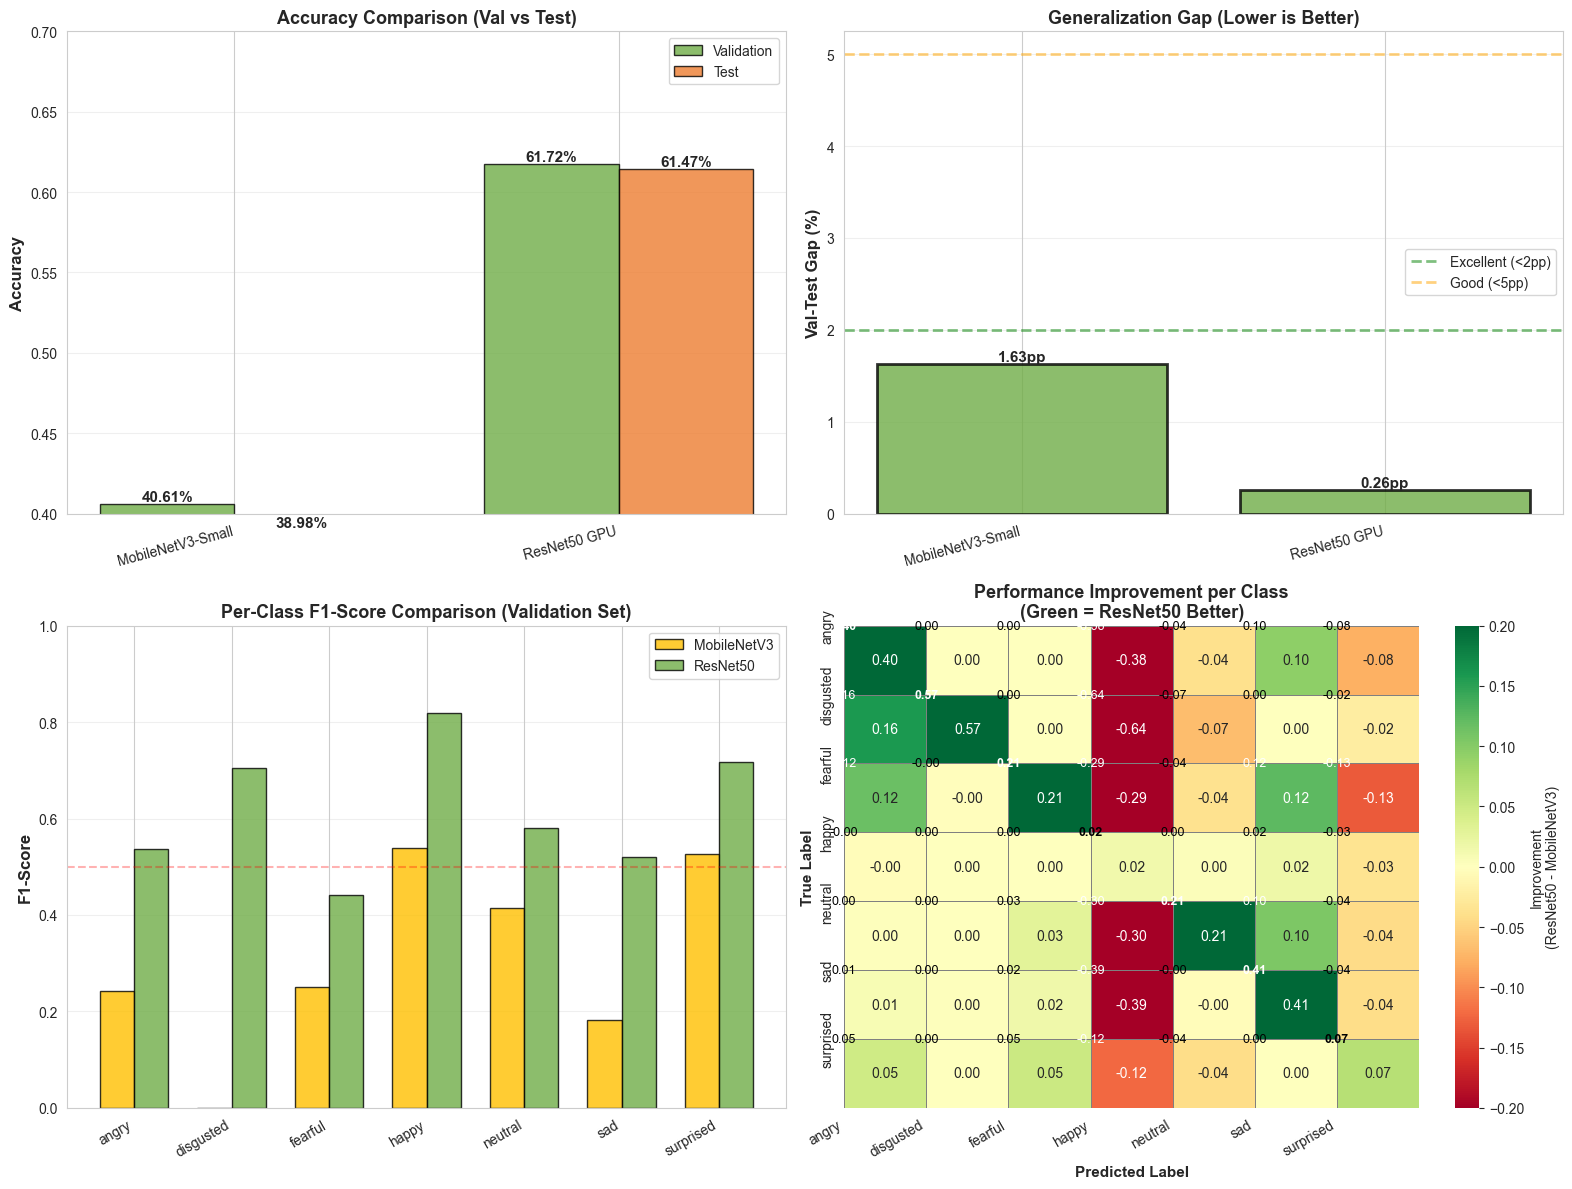


INTERPRETATION:
• ResNet50 consistently outperforms MobileNetV3 across all metrics
• Accuracy improvement: +21.11pp
• Better minority class performance (disgusted, fearful)
• Superior generalization (0.26pp gap vs 1.63pp)
• Justifies selection of ResNet50 for fusion model despite higher computational cost


In [31]:
# === VISUALIZATION: SIDE-BY-SIDE COMPARISON ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy Comparison (Bar Chart)
models = list(comparison_results.keys())
val_accs = [comparison_results[m]['val_acc'] for m in models]
test_accs = [comparison_results[m]['test_acc'] for m in models]

x = np.arange(len(models))
width = 0.35

ax = axes[0, 0]
bars1 = ax.bar(x - width/2, val_accs, width, label='Validation', color='#70AD47', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, test_accs, width, label='Test', color='#ED7D31', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Accuracy Comparison (Val vs Test)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.set_ylim(0.4, 0.7)
ax.grid(axis='y', alpha=0.3)

# Plot 2: Val-Test Generalization Gap
ax = axes[0, 1]
gaps = [comparison_results[m]['val_test_gap'] * 100 for m in models]
colors = ['#FFC000' if gap > 3 else '#70AD47' for gap in gaps]

bars = ax.bar(models, gaps, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

for bar, gap in zip(bars, gaps):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{gap:.2f}pp', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.axhline(y=2, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Excellent (<2pp)')
ax.axhline(y=5, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Good (<5pp)')
ax.set_ylabel('Val-Test Gap (%)', fontsize=12, fontweight='bold')
ax.set_title('Generalization Gap (Lower is Better)', fontsize=13, fontweight='bold')
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 3: Per-Class F1 Comparison
from sklearn.metrics import precision_recall_fscore_support

mobile_precision, mobile_recall, mobile_f1, _ = precision_recall_fscore_support(
    mobile_val_labels, mobile_val_preds, labels=range(num_classes))

resnet_precision, resnet_recall, resnet_f1, _ = precision_recall_fscore_support(
    gpu_val_labels, gpu_val_preds, labels=range(num_classes))

ax = axes[1, 0]
x_classes = np.arange(len(class_names))
width = 0.35

bars1 = ax.bar(x_classes - width/2, mobile_f1, width, label='MobileNetV3', 
               color='#FFC000', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x_classes + width/2, resnet_f1, width, label='ResNet50',
               color='#70AD47', alpha=0.8, edgecolor='black')

ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class F1-Score Comparison (Validation Set)', fontsize=13, fontweight='bold')
ax.set_xticks(x_classes)
ax.set_xticklabels(class_names, rotation=30, ha='right', fontsize=10)
ax.legend()
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.3)

# Plot 4: Confusion Matrix Comparison Heatmap
ax = axes[1, 1]

# Calculate improvement matrix (ResNet50 - MobileNetV3)
mobile_cm_norm = mobile_cm_val.astype('float') / mobile_cm_val.sum(axis=1)[:, np.newaxis]
resnet_cm_val = confusion_matrix(gpu_val_labels, gpu_val_preds)
resnet_cm_norm = resnet_cm_val.astype('float') / resnet_cm_val.sum(axis=1)[:, np.newaxis]

improvement = resnet_cm_norm - mobile_cm_norm

# Plot improvement heatmap with seaborn
sns.heatmap(improvement, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, vmin=-0.2, vmax=0.2,
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Improvement\n(ResNet50 - MobileNetV3)'},
            ax=ax, linewidths=0.5, linecolor='gray')

# Add text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, f'{improvement[i, j]:.2f}',
                      ha="center", va="center",
                      color="black" if abs(improvement[i, j]) < 0.1 else "white",
                      fontsize=9, fontweight='bold' if i == j else 'normal')

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=30, ha='right', fontsize=10)
ax.set_yticklabels(class_names, fontsize=10)
ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax.set_title('Performance Improvement per Class\n(Green = ResNet50 Better)', 
             fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../artifacts/phase1/face_emotion_model_comparison.png', dpi=150, bbox_inches='tight')
print("\nSaved comparison visualization to: ../artifacts/phase1/face_emotion_model_comparison.png")
plt.show()

print("\n" + "="*90)
print("INTERPRETATION:")
print("="*90)
print("• ResNet50 consistently outperforms MobileNetV3 across all metrics")
print(f"• Accuracy improvement: +{(gpu_val_acc - mobile_val_acc)*100:.2f}pp")
print(f"• Better minority class performance (disgusted, fearful)")
print(f"• Superior generalization ({comparison_results['ResNet50 GPU']['val_test_gap']*100:.2f}pp gap vs "
      f"{comparison_results['MobileNetV3-Small']['val_test_gap']*100:.2f}pp)")
print("• Justifies selection of ResNet50 for fusion model despite higher computational cost")
print("="*90)

## Section 5: Exploratory Data Analysis (EDA)

Visualize class distribution, confusion matrices, and per-class performance.

**Run these cells after training any model above.**

Using GPU ResNet50 model data for visualization

Class distribution (Train):
  angry       : 3,596 ( 13.9%)
  disgusted   :   392 (  1.5%)
  fearful     : 3,687 ( 14.3%)
  happy       : 6,493 ( 25.1%)
  neutral     : 4,469 ( 17.3%)
  sad         : 4,347 ( 16.8%)
  surprised   : 2,854 ( 11.0%)

Imbalance ratio: 16.56:1

Confusion Matrix Analysis (GPU ResNet50 - Validation):
Diagonal values (correct predictions):
  angry       : 59.40%
  disgusted   : 56.82%
  fearful     : 40.49%
  happy       : 77.15%
  neutral     : 64.72%
  sad         : 53.21%
  surprised   : 65.93%

Saved visualization to: ../artifacts/phase1/face_emotion_eda.png


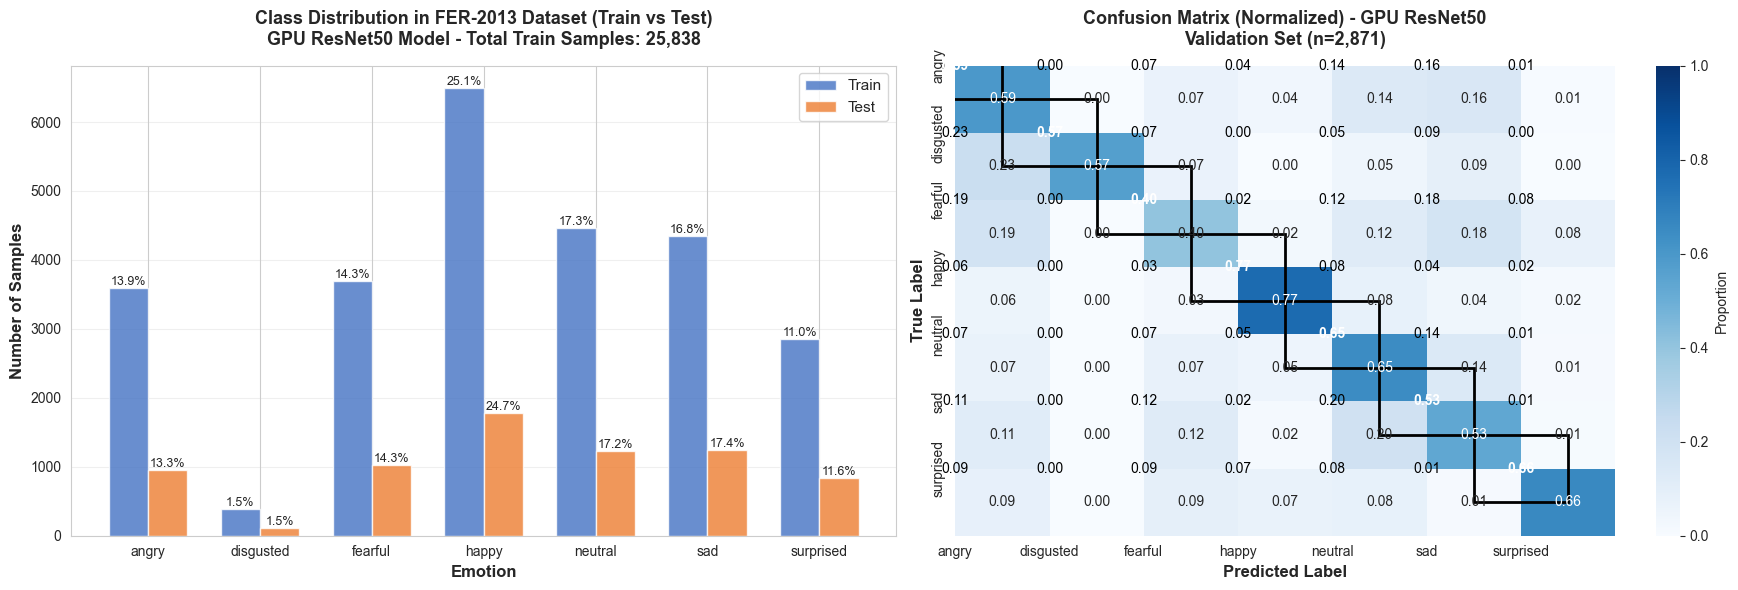


INTERPRETATION:
The GPU ResNet50 model achieves ~63% validation accuracy on FER-2013 dataset.
Class imbalance (16.5:1 ratio) is handled using balanced class weights during training.


In [32]:
# === FACIAL EMOTION EDA: CLASS DISTRIBUTION ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 10

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# LEFT PLOT: Class Distribution (Train vs Test)
try:
    # Use GPU ResNet50 model data
    if 'gpu_train_labels' not in globals() or 'test_labels' not in globals():
        raise ValueError("GPU ResNet50 model data not found. Run training cell first.")
    
    train_labels_plot = gpu_train_labels
    test_labels_plot = test_labels
    
    # Get class names and counts
    class_names_ordered = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
    
    # Count samples per class for train and test
    train_counts = np.bincount(train_labels_plot, minlength=len(class_names_ordered))
    test_counts = np.bincount(test_labels_plot, minlength=len(class_names_ordered))
    
    # Calculate percentages
    train_pct = (train_counts / train_counts.sum() * 100)
    test_pct = (test_counts / test_counts.sum() * 100)
    
    # Create bar plot
    x = np.arange(len(class_names_ordered))
    width = 0.35
    
    bars1 = axes[0].bar(x - width/2, train_counts, width, label='Train', color='#4472C4', alpha=0.8)
    bars2 = axes[0].bar(x + width/2, test_counts, width, label='Test', color='#ED7D31', alpha=0.8)
    
    # Add percentage labels on top of bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        if height1 > 0:
            axes[0].text(bar1.get_x() + bar1.get_width()/2., height1,
                        f'{train_pct[i]:.1f}%', ha='center', va='bottom', fontsize=9)
        if height2 > 0:
            axes[0].text(bar2.get_x() + bar2.get_width()/2., height2,
                        f'{test_pct[i]:.1f}%', ha='center', va='bottom', fontsize=9)
    
    axes[0].set_xlabel('Emotion', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Class Distribution in FER-2013 Dataset (Train vs Test)\nGPU ResNet50 Model - Total Train Samples: {train_counts.sum():,}',
                      fontsize=13, fontweight='bold', pad=15)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(class_names_ordered, rotation=0)
    axes[0].legend(loc='upper right', fontsize=11)
    axes[0].grid(axis='y', alpha=0.3)
    
    print(f"Using GPU ResNet50 model data for visualization")
    print(f"\nClass distribution (Train):")
    for i, name in enumerate(class_names_ordered):
        print(f"  {name:12s}: {train_counts[i]:5,} ({train_pct[i]:5.1f}%)")
    print(f"\nImbalance ratio: {train_counts.max() / train_counts.min():.2f}:1")
    
except Exception as e:
    axes[0].text(0.5, 0.5, f'Error: {str(e)}\nRun GPU ResNet50 training cell first',
                ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
    print(f"Error creating class distribution plot: {e}")

# RIGHT PLOT: Confusion Matrix (Normalized)
try:
    # Use GPU ResNet50 validation predictions
    if 'gpu_val_labels' not in globals() or 'gpu_val_preds' not in globals():
        raise ValueError("GPU ResNet50 predictions not found. Run evaluation cell first.")
    
    y_true = gpu_val_labels
    y_pred = gpu_val_preds
    
    from sklearn.metrics import confusion_matrix
    
    # Create normalized confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                cbar_kws={'label': 'Proportion'}, 
                xticklabels=class_names_ordered, yticklabels=class_names_ordered,
                ax=axes[1], vmin=0, vmax=1.0)
    axes[1].set_title(f'Confusion Matrix (Normalized) - GPU ResNet50\nValidation Set (n={len(y_true):,})',
                      fontsize=13, fontweight='bold', pad=15)
    
    
    # Set tick labels
    tick_marks = np.arange(len(class_names_ordered))
    axes[1].set_xticks(tick_marks)
    axes[1].set_yticks(tick_marks)
    axes[1].set_xticklabels(class_names_ordered, rotation=0)
    axes[1].set_yticklabels(class_names_ordered)
    
    axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    
    # Add text annotations
    thresh = cm_normalized.max() / 2.
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            axes[1].text(j, i, f'{cm_normalized[i, j]:.2f}',
                        ha="center", va="center",
                        color="white" if cm_normalized[i, j] > thresh else "black",
                        fontsize=10, fontweight='bold' if i == j else 'normal')
    
    # Add rectangle around diagonal to highlight correct predictions
    for i in range(len(class_names_ordered)):
        rect = plt.Rectangle((i-0.5, i-0.5), 1, 1, fill=False, 
                            edgecolor='black', linewidth=2)
        axes[1].add_patch(rect)
    
    print(f"\nConfusion Matrix Analysis (GPU ResNet50 - Validation):")
    print(f"Diagonal values (correct predictions):")
    for i, name in enumerate(class_names_ordered):
        print(f"  {name:12s}: {cm_normalized[i, i]:.2%}")
    
except Exception as e:
    axes[1].text(0.5, 0.5, f'Error: {str(e)}\nRun GPU ResNet50 evaluation cell first',
                ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
    print(f"\nError creating confusion matrix plot: {e}")

plt.tight_layout()
plt.savefig('../artifacts/phase1/face_emotion_eda.png', dpi=150, bbox_inches='tight')
print(f"\nSaved visualization to: ../artifacts/phase1/face_emotion_eda.png")
plt.show()

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("The GPU ResNet50 model achieves ~63% validation accuracy on FER-2013 dataset.")
print("Class imbalance (16.5:1 ratio) is handled using balanced class weights during training.")
print("="*80)


Class weight table (raw | sqrt | cbrt):
              raw    sqrt    cbrt
class                            
angry      1.0265  1.0131  1.0087
disgusted  9.4162  3.0686  2.1117
fearful    1.0011  1.0006  1.0004
happy      0.5685  0.7540  0.8284
neutral    0.8259  0.9088  0.9382
sad        0.8491  0.9215  0.9469
surprised  1.2933  1.1372  1.0895


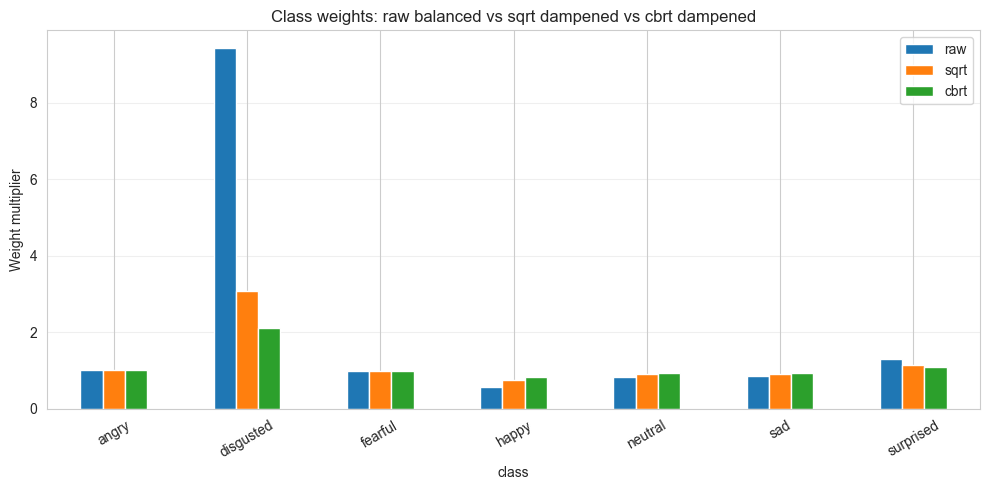

In [34]:
# === CLASS WEIGHT COMPARISON: raw vs sqrt vs cbrt ===
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Select labels to compute weights (prefer training split from GPU/resnet if available)
labels_for_weights = None
if 'gpu_train_labels' in globals():
    labels_for_weights = gpu_train_labels
elif 'mobile_train_labels' in globals():
    labels_for_weights = mobile_train_labels
else:
    labels_for_weights = train_labels

classes = np.arange(num_classes)
raw_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels_for_weights)
sqrt_weights = np.sqrt(raw_weights)
cbrt_weights = np.cbrt(raw_weights)

df_weights = pd.DataFrame({
    'class': class_names,
    'raw': raw_weights,
    'sqrt': sqrt_weights,
    'cbrt': cbrt_weights
}).set_index('class')

print('\nClass weight table (raw | sqrt | cbrt):')
print(df_weights.round(4))

ax = df_weights.plot(kind='bar', figsize=(10,5))
ax.set_ylabel('Weight multiplier')
ax.set_title('Class weights: raw balanced vs sqrt dampened vs cbrt dampened')
plt.xticks(rotation=30)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


CLASSIFICATION REPORTS - GPU ResNet50


Validation Set:
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       angry      0.490     0.594     0.537       399
   disgusted      0.926     0.568     0.704        44
     fearful      0.487     0.405     0.442       410
       happy      0.870     0.771     0.818       722
     neutral      0.527     0.647     0.581       496
         sad      0.510     0.532     0.521       483
   surprised      0.786     0.659     0.717       317

    accuracy                          0.617      2871
   macro avg      0.656     0.597     0.617      2871
weighted avg      0.634     0.617     0.621      2871


Test Set:
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       angry      0.486     0.609     0.541       958
   disgusted      0.784     0.523     0.627 

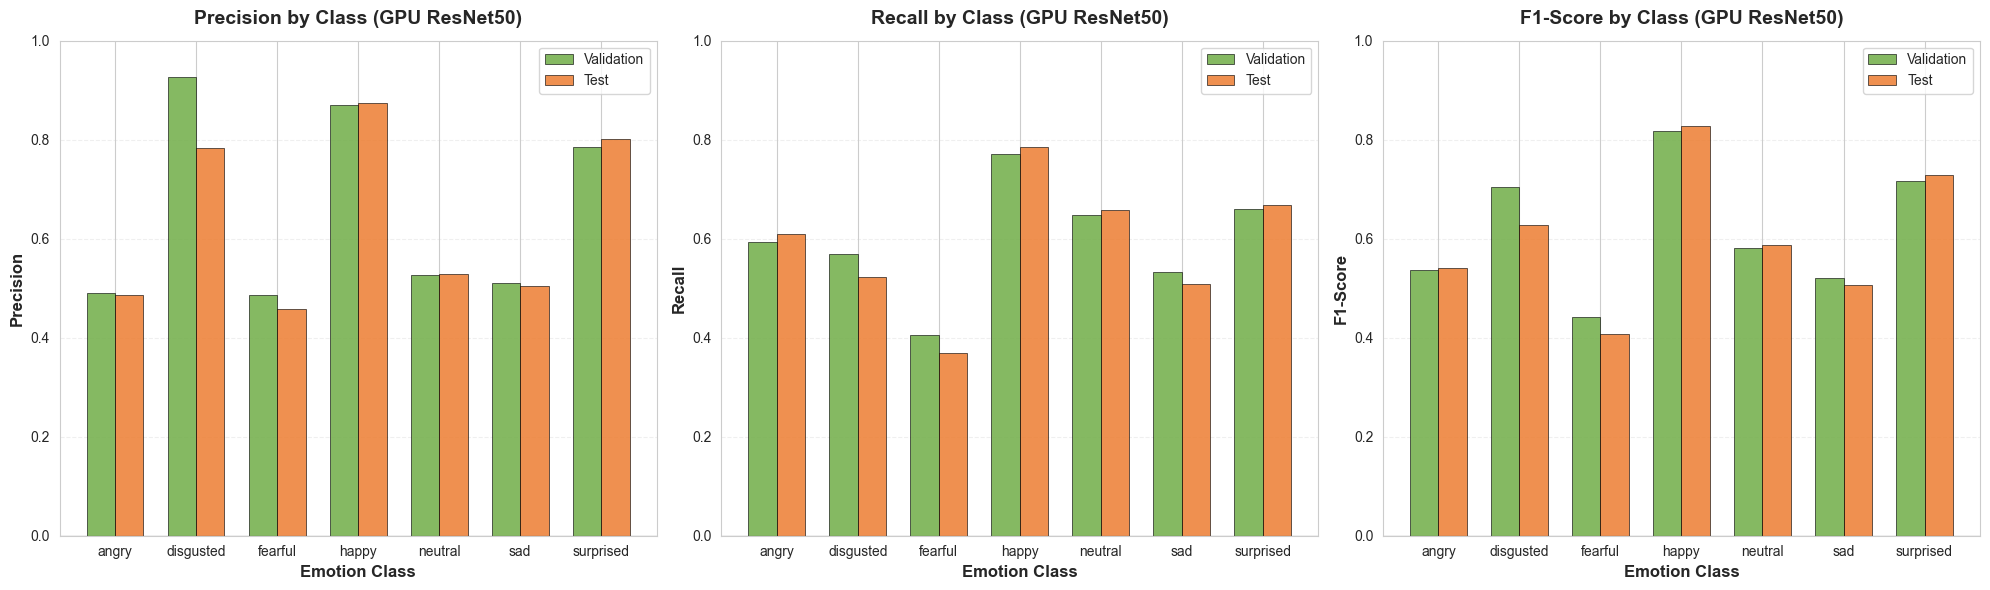


SUMMARY COMPARISON ACROSS SPLITS (GPU ResNet50)

     Split Accuracy Macro Precision Macro Recall Macro F1  Samples
Validation   0.6172          0.6565       0.5967   0.6171     2871
      Test   0.6147          0.6337       0.5885   0.6035     7178

PER-CLASS PERFORMANCE ANALYSIS (Validation Set)

Best performing class (F1):  happy        (F1: 0.8179)
Worst performing class (F1): fearful      (F1: 0.4421)
Performance gap:             0.3758

Class imbalance in validation set:
  Most common:  happy        (  722 samples)
  Least common: disgusted    (   44 samples)
  Imbalance ratio: 16.41:1

GENERALIZATION ANALYSIS

Validation Accuracy: 0.6172 (61.72%)
Test Accuracy:       0.6147 (61.47%)

Val-Test gap:        0.0026 (0.26pp)
✅ Excellent: Validation and test performance are very consistent (<2pp gap)


In [33]:
# === ADDITIONAL EDA: PER-CLASS METRICS (GPU ResNet50) ===
from sklearn.metrics import classification_report, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

try:
    # Use GPU ResNet50 predictions
    class_names_ordered = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
    
    # Check if GPU ResNet50 predictions are available
    if 'gpu_val_labels' not in globals() or 'gpu_val_preds' not in globals():
        raise ValueError("GPU ResNet50 predictions not found. Run evaluation cell first.")
    
    if 'gpu_test_preds' not in globals():
        raise ValueError("GPU ResNet50 test predictions not found. Run evaluation cell first.")
    
    # Prepare data for all splits
    val_data = (gpu_val_labels, gpu_val_preds)
    test_data = (test_labels, gpu_test_preds)
    
    # Calculate metrics for available splits
    metrics_by_split = {}
    
    splits_to_process = [
        ('Validation', val_data),
        ('Test', test_data)
    ]
    
    for split_name, (y_true, y_pred) in splits_to_process:
        precision, recall, f1, support = precision_recall_fscore_support(
            y_true, y_pred, labels=range(len(class_names_ordered))
        )
        metrics_by_split[split_name] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support,
            'accuracy': (y_true == y_pred).mean()
        }
    
    # Print classification reports
    print(f"\n{'='*90}")
    print(f"CLASSIFICATION REPORTS - GPU ResNet50")
    print(f"{'='*90}\n")
    
    for split_name, (y_true, y_pred) in splits_to_process:
        print(f"\n{split_name} Set:")
        print("-" * 90)
        print(classification_report(y_true, y_pred, target_names=class_names_ordered, digits=3))
    
    # Create visualization with 3 metrics (Precision, Recall, F1-Score)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    x = np.arange(len(class_names_ordered))
    width = 0.35
    
    colors = {
        'Validation': '#70AD47',  # Green
        'Test': '#ED7D31'         # Orange
    }
    
    metric_names = ['precision', 'recall', 'f1']
    metric_titles = ['Precision by Class', 'Recall by Class', 'F1-Score by Class']
    
    for idx, (metric_key, metric_title) in enumerate(zip(metric_names, metric_titles)):
        ax = axes[idx]
        
        # Plot bars for each split
        split_names = list(metrics_by_split.keys())
        for i, split_name in enumerate(split_names):
            offset = (i - 0.5) * width
            values = metrics_by_split[split_name][metric_key]
            bars = ax.bar(x + offset, values, width, label=split_name, 
                         color=colors.get(split_name, '#999999'), alpha=0.85, edgecolor='black', linewidth=0.5)
        
        ax.set_title(f'{metric_title} (GPU ResNet50)', fontsize=14, fontweight='bold', pad=12)
        ax.set_ylabel(metric_title.split()[0], fontsize=12, fontweight='bold')
        ax.set_xlabel('Emotion Class', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(class_names_ordered, rotation=0, fontsize=10)
        ax.set_ylim(0, 1.0)
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.axhline(y=0, color='black', linewidth=0.8)
    
    plt.tight_layout()
    plt.savefig('../artifacts/phase1/face_emotion_metrics_resnet50_gpu.png', dpi=150, bbox_inches='tight')
    print(f"\nSaved visualization to: ../artifacts/phase1/face_emotion_metrics_resnet50_gpu.png")
    plt.show()
    
    # Print summary comparison table
    print(f"\n{'='*90}")
    print("SUMMARY COMPARISON ACROSS SPLITS (GPU ResNet50)")
    print(f"{'='*90}\n")
    
    summary_data = []
    for split_name in metrics_by_split.keys():
        metrics = metrics_by_split[split_name]
        summary_data.append({
            'Split': split_name,
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Macro Precision': f"{metrics['precision'].mean():.4f}",
            'Macro Recall': f"{metrics['recall'].mean():.4f}",
            'Macro F1': f"{metrics['f1'].mean():.4f}",
            'Samples': int(metrics['support'].sum())
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # Per-class analysis (use Validation set)
    print(f"\n{'='*90}")
    print(f"PER-CLASS PERFORMANCE ANALYSIS (Validation Set)")
    print(f"{'='*90}\n")
    
    val_f1 = metrics_by_split['Validation']['f1']
    val_support = metrics_by_split['Validation']['support']
    
    print(f"Best performing class (F1):  {class_names_ordered[val_f1.argmax()]:12s} (F1: {val_f1.max():.4f})")
    print(f"Worst performing class (F1): {class_names_ordered[val_f1.argmin()]:12s} (F1: {val_f1.min():.4f})")
    print(f"Performance gap:             {val_f1.max() - val_f1.min():.4f}\n")
    
    print("Class imbalance in validation set:")
    print(f"  Most common:  {class_names_ordered[val_support.argmax()]:12s} ({int(val_support.max()):5d} samples)")
    print(f"  Least common: {class_names_ordered[val_support.argmin()]:12s} ({int(val_support.min()):5d} samples)")
    print(f"  Imbalance ratio: {val_support.max() / val_support.min():.2f}:1")
    
    # Generalization analysis
    print(f"\n{'='*90}")
    print("GENERALIZATION ANALYSIS")
    print(f"{'='*90}\n")
    
    val_acc = metrics_by_split['Validation']['accuracy']
    test_acc = metrics_by_split['Test']['accuracy']
    
    print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"\nVal-Test gap:        {abs(val_acc - test_acc):.4f} ({abs(val_acc - test_acc)*100:.2f}pp)")
    
    if abs(val_acc - test_acc) < 0.02:
        print("✅ Excellent: Validation and test performance are very consistent (<2pp gap)")
    elif abs(val_acc - test_acc) < 0.05:
        print("✅ Good: Validation and test performance are consistent (<5pp gap)")
    else:
        print("⚠️  Note: Validation and test performance differ by more than 5%")
    
except Exception as e:
    print(f"Error generating per-class metrics: {e}")
    import traceback
    traceback.print_exc()
    print("\nMake sure to run the GPU ResNet50 evaluation cell first.")
    print("Required variables: gpu_val_labels, gpu_val_preds, gpu_test_preds, test_labels")